#### Imports

In [1]:
import sys
import os
import os.path

import numpy as np
import skimage.io
import glob

import shutil
#from config import config_vars

from tqdm import tqdm

import matplotlib.pyplot as plt
import skimage.morphology

import tensorflow as tf
import keras

import utils.metrics
import utils.model_builder
from skimage.transform import resize

Using TensorFlow backend.


#### Prerequisites
> First step is to convert from C01 to tiff using "convert-images-to-tiff-updated.ipynb"
> 
> Put the tiff-files in a directory and change the paths below

#### Convert from tiff to png + normalize 

In [58]:
flist = sorted(os.listdir('/home/jupyter/aitslab_images'))

fdir = '/home/jupyter/aitslab_images/'

# run over all raw images
for filename in tqdm(flist):
    if filename != ".ipynb_checkpoints" and filename != "norm_images" and filename != "boundary_labels":
        

        # load image and its annotation
        orig_img = skimage.io.imread(fdir + filename, plugin='matplotlib')       

        # IMAGE

        # normalize to [0,1]
        percentile = 99.9
        high = np.percentile(orig_img, percentile)
        low = np.percentile(orig_img, 100-percentile)

        img = np.minimum(high, orig_img)
        img = np.maximum(low, img)

        img = (img - low) / (high - low) # gives float64, thus cast to 8 bit later
        img = skimage.img_as_ubyte(img) 

        skimage.io.imsave(fdir + "/norm_images/" + filename[:-4] + 'png', img)    


100%|██████████| 17/17 [00:04<00:00,  3.66it/s]


#### View result:

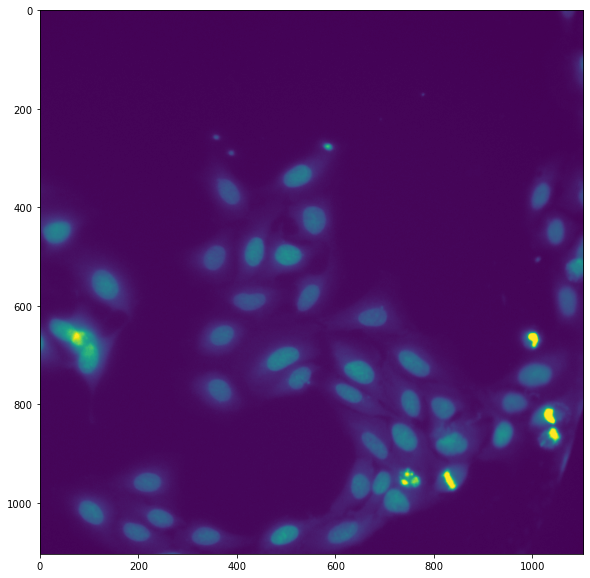

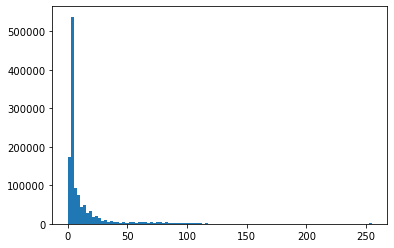

uint8 (1104, 1104)


In [59]:
filename = os.listdir('/home/jupyter/aitslab_images/norm_images')

img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[-1])
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()
plt.hist(img.flatten(), bins=100)
plt.show()
print(img.dtype, img.shape)

#### Compare to BBBC images

In [4]:
from config import config_vars


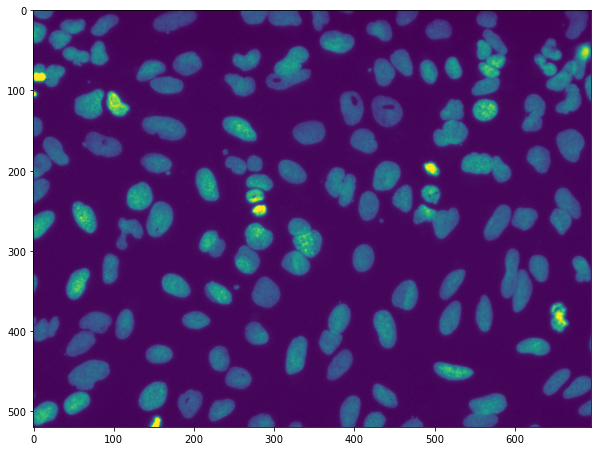

uint8 (520, 696)


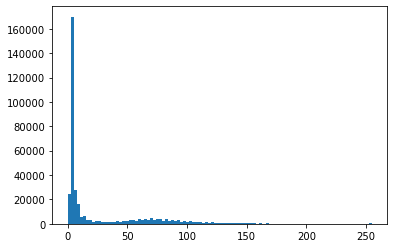

In [7]:
filename = os.listdir(config_vars["normalized_images_dir"])
img = skimage.io.imread(config_vars["normalized_images_dir"] + filename[-1])
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()
print(img.dtype, img.shape)
plt.hist(img.flatten(), bins=100)
plt.show()

### Make predictions on images from Aitslab

#### Config

In [ ]:
from config import config_vars

# Partition of the data to make predictions (test or validation)
partition = "validation"

experiment_name = 'aits2' #convert to 520x696 (same as BBBC)

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

data_partitions = utils.dirtools.read_data_partitions(config_vars)

config_vars

In [4]:
# Use the following configuration if you want to test on CPUs
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
# configuration = tf.ConfigProto(
#       intra_op_parallelism_threads=1,
#       inter_op_parallelism_threads=1)

configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "0"
session = tf.compat.v1.Session(config = configuration)

# apply session
session = tf.compat.v1.keras.backend.set_session(session)

# apply session
tf.compat.v1.keras.backend.set_session(session)

#### preprocess images and load model

In [2]:
filename = os.listdir('/home/jupyter/aitslab_images/norm_images')

In [35]:
image_names = [os.path.join('/home/jupyter/aitslab_images/norm_images', f) for f in filename]
image_names.remove('/home/jupyter/aitslab_images/norm_images/.ipynb_checkpoints')

imagebuffer = skimage.io.imread_collection(image_names)

images = imagebuffer.concatenate()
images2 = list()
for i in images:
    i = resize(i, (520, 696), mode='constant', preserve_range=True)
    images2.append(i)


dim1 = images2.shape[1]
dim2 = images2.shape[2]
#images = images[:, 0:dim1, 0:dim2]

images2 = images2.reshape((-1, dim1, dim2, 1))



# preprocess (assuming images are encoded as 8-bits in the preprocessing step)
images2 = images2 / 255

# build model and load weights
model = utils.model_builder.get_model_3_class(dim1, dim2)
#model.load_weights(config_vars["model_file"])
model.load_weights('/home/jupyter/experiments/01/model.hdf5')

# Normal prediction time
predictions = model.predict(images2, batch_size=1)

#model.summary()

#### Plot prob map, predictions and labels

In [ ]:
for i in range(len(images)):

    filename = imagebuffer.files[i]
    filename = os.path.basename(filename)
    print(filename)
    
    probmap = predictions[i].squeeze()
    
    plt.imshow(probmap)
    plt.show()
    
    skimage.io.imsave(config_vars["probmap_out_dir"] + filename, probmap)
    
    pred = utils.metrics.probmap_to_pred(probmap, config_vars["boundary_boost_factor"])

    plt.imshow(pred)
    plt.show()
    
    label = utils.metrics.pred_to_label(pred, config_vars["cell_min_size"])
    
    plt.imshow(label)
    plt.show()
    
    skimage.io.imsave(config_vars["labels_out_dir"] + filename, label)

### Comparison between ground truth and prediction for different images scales

##### Without reshaping images (1104x1104)

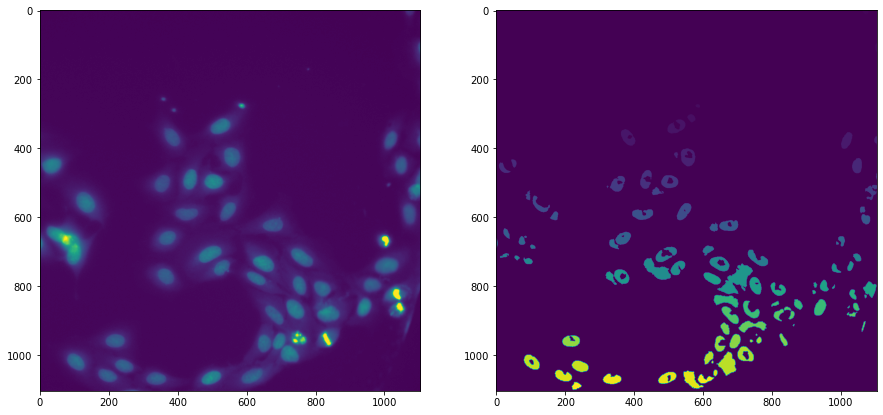

In [37]:
f, axs = plt.subplots(1,2,figsize=(15,15))

filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[-1])

filename2 = os.listdir('/home/jupyter/experiments/aits/out/segm')
img2 = skimage.io.imread('/home/jupyter/experiments/aits/out/segm/' + filename[-1])



axs[0].imshow(img)
axs[1].imshow(img2)


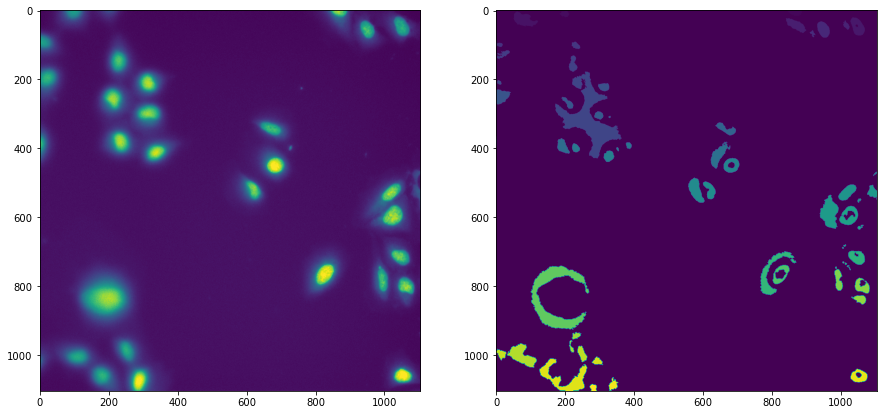

In [40]:
f, axs = plt.subplots(1,2,figsize=(15,15))

filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[0])

filename2 = os.listdir('/home/jupyter/experiments/aits/out/segm')
img2 = skimage.io.imread('/home/jupyter/experiments/aits/out/segm/' + filename[0])



axs[0].imshow(img)
axs[1].imshow(img2)


#### Converting images to same shape as bbbc-images (520x696):

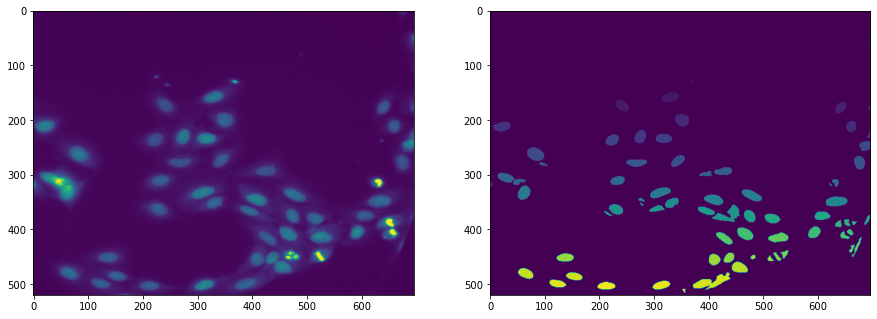

In [44]:
f, axs = plt.subplots(1,2,figsize=(15,15))

filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[-1])

img = resize(img, (520, 696), mode='constant', preserve_range=True)

filename2 = os.listdir('/home/jupyter/experiments/aits2/out/segm')
img2 = skimage.io.imread('/home/jupyter/experiments/aits2/out/segm/' + filename[-1])



axs[0].imshow(img)
axs[1].imshow(img2)


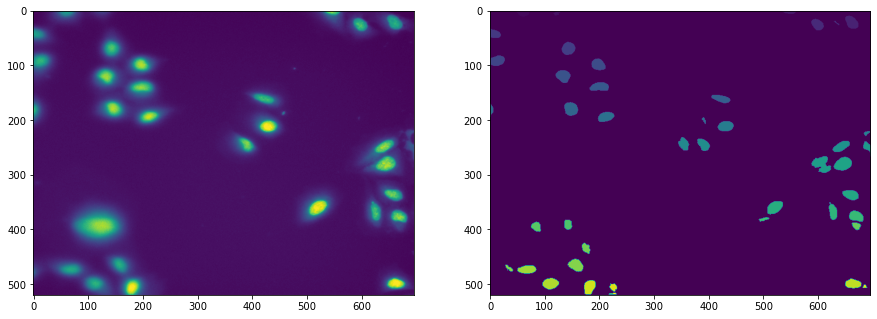

In [45]:
f, axs = plt.subplots(1,2,figsize=(15,15))

filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[0])

img = resize(img, (520, 696), mode='constant', preserve_range=True)

filename2 = os.listdir('/home/jupyter/experiments/aits2/out/segm')
img2 = skimage.io.imread('/home/jupyter/experiments/aits2/out/segm/' + filename[0])



axs[0].imshow(img)
axs[1].imshow(img2)


##### Comparison between real, otsu's and current model prediction

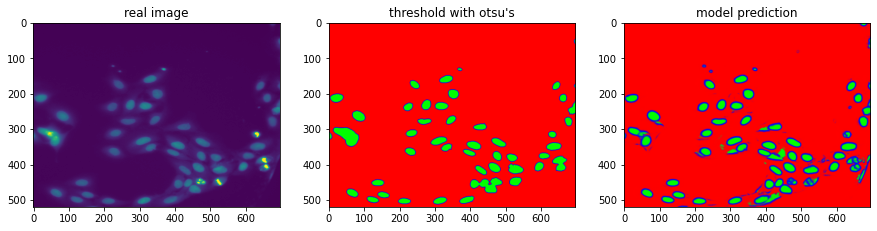

In [17]:
filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[-1])
img = resize(img, (520, 696), mode='constant', preserve_range=True)
threshold_images = os.listdir('/home/jupyter/aitslab_images/boundary_labels')
threshold_image_names = [os.path.join('/home/jupyter/aitslab_images/boundary_labels/', f) for f in filename]
threshold_image_names.remove('/home/jupyter/aitslab_images/boundary_labels/.ipynb_checkpoints')
thresh = skimage.io.imread(threshold_image_names[7])
f2 = os.listdir('/home/jupyter/experiments/aits2/out/prob')
i2 = skimage.io.imread('/home/jupyter/experiments/aits2/out/prob/' + filename[-1])

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title("real image")
plt.imshow(img)
plt.subplot(132)
plt.title("threshold with otsu's")
plt.imshow(thresh)
plt.subplot(133)
plt.title("model prediction")
plt.imshow(i2)
plt.savefig("comp.png")

#### Reshaping to same size as network is trained on (256x256)

In [ ]:
from config import config_vars

# Partition of the data to make predictions (test or validation)
partition = "validation"

experiment_name = 'aits3' #converted to 256x256 (same as network is trained on)

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

data_partitions = utils.dirtools.read_data_partitions(config_vars)

config_vars

In [50]:
image_names = [os.path.join('/home/jupyter/aitslab_images/norm_images', f) for f in filename]
image_names.remove('/home/jupyter/aitslab_images/norm_images/.ipynb_checkpoints')

imagebuffer = skimage.io.imread_collection(image_names)

images = imagebuffer.concatenate()
images2 = list()
for i in images:
    i = resize(i, (256, 256), mode='constant', preserve_range=True)
    images2.append(i)
images2 = np.asarray(images2)



dim1 = images2.shape[1]
dim2 = images2.shape[2]
#images = images[:, 0:dim1, 0:dim2]

images2 = images2.reshape((-1, dim1, dim2, 1))



# preprocess (assuming images are encoded as 8-bits in the preprocessing step)
images2 = images2 / 255

# build model and load weights
model = utils.model_builder.get_model_3_class(dim1, dim2)
#model.load_weights(config_vars["model_file"])
model.load_weights('/home/jupyter/experiments/01/model.hdf5')

# Normal prediction time
predictions = model.predict(images2, batch_size=1)

#model.summary()

In [ ]:
for i in range(len(images)):

    filename = imagebuffer.files[i]
    filename = os.path.basename(filename)
    print(filename)
    
    probmap = predictions[i].squeeze()
    
    plt.imshow(probmap)
    plt.show()
    
    skimage.io.imsave(config_vars["probmap_out_dir"] + filename, probmap)
    
    pred = utils.metrics.probmap_to_pred(probmap, config_vars["boundary_boost_factor"])

    plt.imshow(pred)
    plt.show()
    
    label = utils.metrics.pred_to_label(pred, config_vars["cell_min_size"])
    
    plt.imshow(label)
    plt.show()
    
    skimage.io.imsave(config_vars["labels_out_dir"] + filename, label)

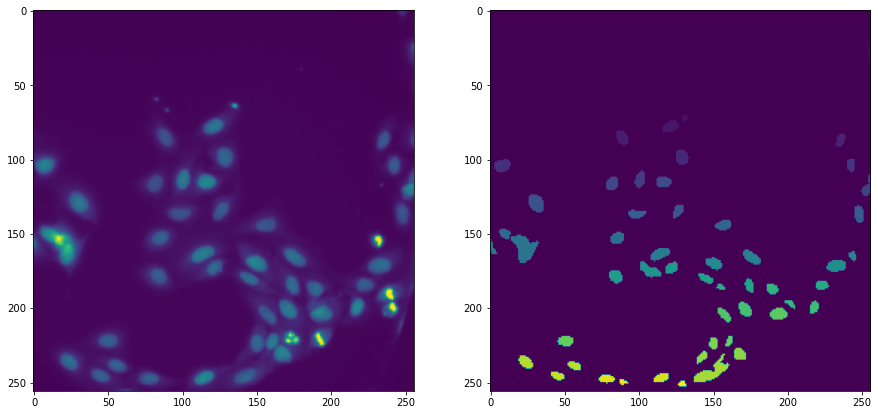

In [53]:
f, axs = plt.subplots(1,2,figsize=(15,15))

filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[-1])

img = resize(img, (256, 256), mode='constant', preserve_range=True)

filename2 = os.listdir('/home/jupyter/experiments/aits3/out/segm')
img2 = skimage.io.imread('/home/jupyter/experiments/aits3/out/segm/' + filename[-1])



axs[0].imshow(img)
axs[1].imshow(img2)


In [55]:
#TODO: plot these next to each other

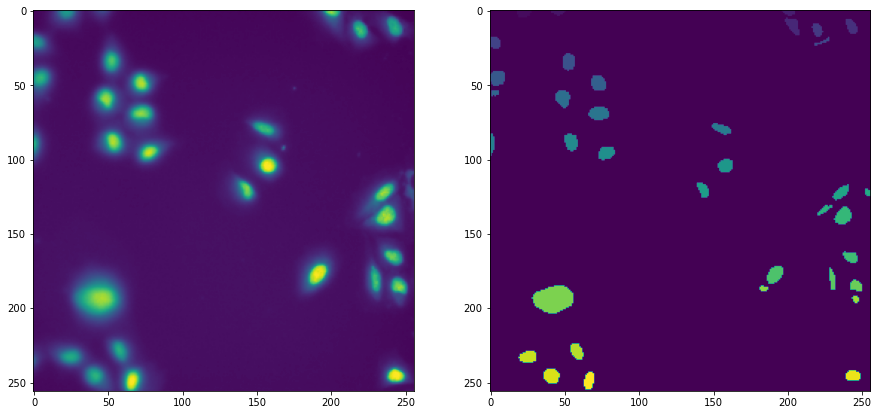

In [60]:
f, axs = plt.subplots(1,2,figsize=(15,15))

filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[0])

img = resize(img, (256, 256), mode='constant', preserve_range=True)

filename2 = os.listdir('/home/jupyter/experiments/aits3/out/segm')
img2 = skimage.io.imread('/home/jupyter/experiments/aits3/out/segm/' + filename[0])



axs[0].imshow(img)
axs[1].imshow(img2)


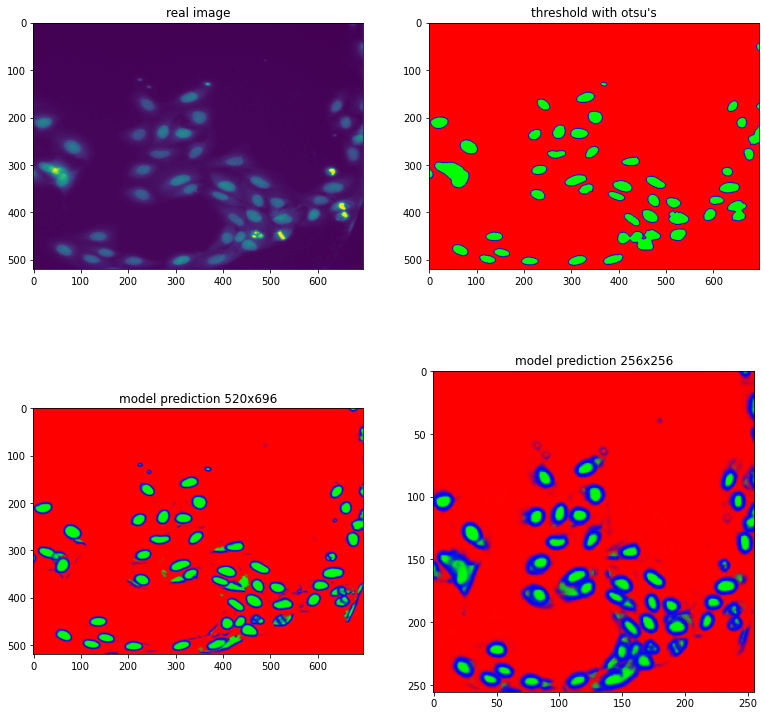

In [2]:
filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[-1])
img = resize(img, (520, 696), mode='constant', preserve_range=True)
threshold_images = os.listdir('/home/jupyter/aitslab_images/boundary_labels')
threshold_image_names = [os.path.join('/home/jupyter/aitslab_images/boundary_labels/', f) for f in filename]
threshold_image_names.remove('/home/jupyter/aitslab_images/boundary_labels/.ipynb_checkpoints')
thresh = skimage.io.imread(threshold_image_names[7])
f2 = os.listdir('/home/jupyter/experiments/aits3/out/prob')
i2 = skimage.io.imread('/home/jupyter/experiments/aits2/out/prob/' + filename[-1])
i3 = skimage.io.imread('/home/jupyter/experiments/aits3/out/prob/' + filename[-1])

plt.figure(figsize=(13,13))
plt.subplot(221)
plt.title("real image")
plt.imshow(img)
plt.subplot(222)
plt.title("threshold with otsu's")
plt.imshow(thresh)
plt.subplot(223)
plt.title("model prediction 520x696")
plt.imshow(i2)
plt.subplot(224)
plt.title("model prediction 256x256")
plt.imshow(i3)
#plt.savefig("comp.png")

In [ ]:
filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[0])
img = resize(img, (520, 696), mode='constant', preserve_range=True)
threshold_images = os.listdir('/home/jupyter/aitslab_images/boundary_labels')
threshold_image_names = [os.path.join('/home/jupyter/aitslab_images/boundary_labels/', f) for f in filename]
threshold_image_names.remove('/home/jupyter/aitslab_images/boundary_labels/.ipynb_checkpoints')
thresh = skimage.io.imread(threshold_image_names[9])
f2 = os.listdir('/home/jupyter/experiments/aits3/out/prob')
i2 = skimage.io.imread('/home/jupyter/experiments/aits2/out/prob/' + filename[0])
i3 = skimage.io.imread('/home/jupyter/experiments/aits3/out/prob/' + filename[0])

plt.figure(figsize=(13,13))
plt.subplot(141)
plt.title("real image")
plt.imshow(img)
plt.subplot(142)
plt.title("threshold with otsu's")
plt.imshow(thresh)
plt.subplot(143)
plt.title("model prediction 520x696")
plt.imshow(i2)
plt.savefig("comp.png")
plt.subplot(144)
plt.title("model prediction 256x256")
plt.imshow(i3)
plt.savefig("comp.png")

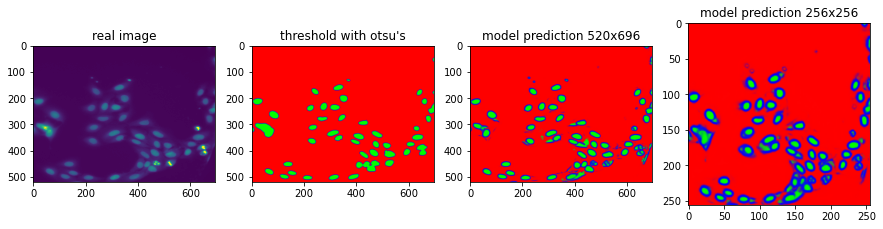

In [18]:
filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[-1])
img = resize(img, (520, 696), mode='constant', preserve_range=True)
threshold_images = os.listdir('/home/jupyter/aitslab_images/boundary_labels')
threshold_image_names = [os.path.join('/home/jupyter/aitslab_images/boundary_labels/', f) for f in filename]
threshold_image_names.remove('/home/jupyter/aitslab_images/boundary_labels/.ipynb_checkpoints')
thresh = skimage.io.imread(threshold_image_names[7])
f2 = os.listdir('/home/jupyter/experiments/aits3/out/prob')
i2 = skimage.io.imread('/home/jupyter/experiments/aits2/out/prob/' + filename[-1])
i3 = skimage.io.imread('/home/jupyter/experiments/aits3/out/prob/' + filename[-1])

plt.figure(figsize=(15,15))
plt.subplot(141)
plt.title("real image")
plt.imshow(img)
plt.subplot(142)
plt.title("threshold with otsu's")
plt.imshow(thresh)
plt.subplot(143)
plt.title("model prediction 520x696")
plt.imshow(i2)
plt.subplot(144)
plt.title("model prediction 256x256")
plt.imshow(i3)
#plt.savefig("comp.png")

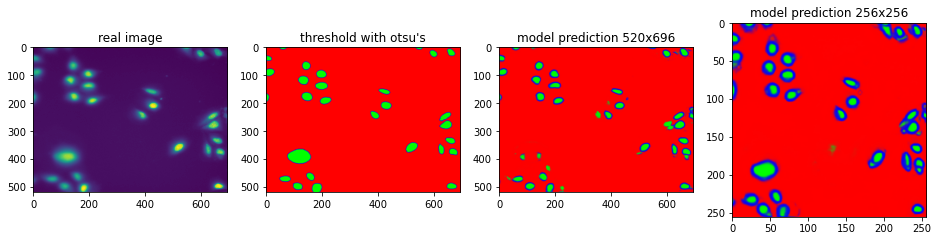

In [20]:
filename = os.listdir('/home/jupyter/aitslab_images/norm_images')
img = skimage.io.imread('/home/jupyter/aitslab_images/norm_images/' + filename[0])
img = resize(img, (520, 696), mode='constant', preserve_range=True)
threshold_images = os.listdir('/home/jupyter/aitslab_images/boundary_labels')
threshold_image_names = [os.path.join('/home/jupyter/aitslab_images/boundary_labels/', f) for f in filename]
threshold_image_names.remove('/home/jupyter/aitslab_images/boundary_labels/.ipynb_checkpoints')
thresh = skimage.io.imread(threshold_image_names[9])
f2 = os.listdir('/home/jupyter/experiments/aits3/out/prob')
i2 = skimage.io.imread('/home/jupyter/experiments/aits2/out/prob/' + filename[0])
i3 = skimage.io.imread('/home/jupyter/experiments/aits3/out/prob/' + filename[0])

plt.figure(figsize=(16,16))
plt.subplot(141)
plt.title("real image")
plt.imshow(img)
plt.subplot(142)
plt.title("threshold with otsu's")
plt.imshow(thresh)
plt.subplot(143)
plt.title("model prediction 520x696")
plt.imshow(i2)
plt.savefig("comp.png")
plt.subplot(144)
plt.title("model prediction 256x256")
plt.imshow(i3)
plt.savefig("comp.png")

In [21]:
#thresh = skimage.io.imread(threshold_image_names[9])
#plt.imshow(thresh)